In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")



In [3]:
data=pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")

with open("../3. EDA and data preprocessing/time_dependent_clinical_features.txt", 'r') as file:
    clinical_feature_time_dependent = file.readlines()
clinical_feature_time_dependent = [item.strip() for item in clinical_feature_time_dependent]

with open("../3. EDA and data preprocessing/static_clinical_features.txt", 'r') as file:
    clinical_feature_non_time_dependent = file.readlines()
clinical_feature_non_time_dependent = [item.strip() for item in clinical_feature_non_time_dependent] 

In [4]:
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']
cols_to_lag = updrs_cols + clinical_feature_time_dependent

data = data.sort_values(['participant_id', 'visit_month'])

for lag in [1, 2, 3]: 
    for col in cols_to_lag:
        data[f'{col}_lag_{lag}'] = data.groupby('participant_id')[col].shift(lag)


lagged_feature_cols = [col for col in data.columns if '_lag_' in col]
final_feature_cols = clinical_feature_non_time_dependent + lagged_feature_cols

In [5]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

mae_results = {}
mae_results["0"]=defaultdict(list)
mae_results["1"]=defaultdict(list)
mae_results["2"]=defaultdict(list)

cv_split_generator = gkf.split(data, groups=data["participant_id"])

print("Starting cross-validation for Random Forest with Lagged Features...")

for fold, (train_idx, test_idx) in enumerate(tqdm(cv_split_generator, total=n_splits, desc="Running CV")):
    train_fold = data.iloc[train_idx]
    holdout_fold = data.iloc[test_idx]


    X_train, y_train = train_fold[final_feature_cols], train_fold[updrs_cols]
    X_holdout, y_holdout = holdout_fold[final_feature_cols], holdout_fold[updrs_cols]


    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)

    X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=final_feature_cols, index=X_train.index)
    X_holdout_imputed = pd.DataFrame(imputer.transform(X_holdout), columns=final_feature_cols, index=X_holdout.index)


    y_train_clean = y_train.dropna()
    X_train_clean = X_train_imputed.loc[y_train_clean.index]

    xgb_estimator = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,  
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method='hist' 
    )
    model1 = MultiOutputRegressor(xgb_estimator)


    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model2 = MultiOutputRegressor(rf)

    lgbm_estimator = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    model3 = MultiOutputRegressor(lgbm_estimator)

    models=[model1, model2, model3]
    for i, model in enumerate(models):
      model.fit(X_train_clean, y_train_clean)

      predictions_array = model.predict(X_holdout_imputed)
      predictions_df = pd.DataFrame(predictions_array, index=X_holdout.index, columns=updrs_cols)

      for col in updrs_cols:
          actual_values = y_holdout[col]
          predicted_values = predictions_df[col]

          valid_indices = actual_values.notna()
          mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])

          mae_results[f"{i}"][col].append(mae)


Starting cross-validation for Random Forest with Lagged Features...


Running CV:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
for i in range(0,3):
  if i==0:
    print("\n--- Cross-Validation Results for XG Boosting w/ Lags ---")
  elif i==1:
    print("\n--- Cross-Validation Results for Random Forest w/ Lags ---")
  else:
    print("\n--- Cross-Validation Results for LightGBM w/ Lags ---")
  for col, scores in mae_results[f"{i}"].items():
      avg_mae = np.mean(scores)
      std_mae = np.std(scores)
      print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Cross-Validation Results for XG Boosting w/ Lags ---
Average MAE for updrs_1: 2.7464 (+/- 0.0327)
Average MAE for updrs_2: 2.7410 (+/- 0.0116)
Average MAE for updrs_3: 5.9895 (+/- 0.0658)

--- Cross-Validation Results for Random Forest w/ Lags ---
Average MAE for updrs_1: 2.7986 (+/- 0.0270)
Average MAE for updrs_2: 2.7826 (+/- 0.0238)
Average MAE for updrs_3: 6.0751 (+/- 0.0542)

--- Cross-Validation Results for LightGBM w/ Lags ---
Average MAE for updrs_1: 2.6568 (+/- 0.0341)
Average MAE for updrs_2: 2.5800 (+/- 0.0286)
Average MAE for updrs_3: 5.8017 (+/- 0.0443)


# Observations:

Compared to the baseline models, the tree models with lags achieved a large improvement. This confirm with our knowledge about time series data: the trend is the most important feature.

Since the LightGBM model has the best performance here, we will use that model in the subsequent modelling process.

In order to prepare for the later feature engineering, we roughly look at the feature importance for the LightBGM model in the last fold.


--- Feature Importance (from last fold's model) ---
Top 20 Features (Averaged Across UPDRS Targets):
                                         updrs_1  updrs_2  updrs_3  \
updrs_3_lag_1                               1944     2524     2627   
age_at_baseline                             1225     2370     2119   
updrs_3_lag_3                               1471     1735     2014   
updrs_3_lag_2                               1606     1030     2386   
updrs_2_lag_3                                953     2525     1491   
visit_month                                 1480      860     2601   
updrs_1_lag_1                               1801     1721     1146   
updrs_1_lag_2                               1268     2530      784   
updrs_2_lag_1                               1184     1922      839   
updrs_2_lag_2                               1057     1851      696   
updrs_1_lag_3                               1266     1657      642   
sbr_caudate_l_lag_3                          854      410 

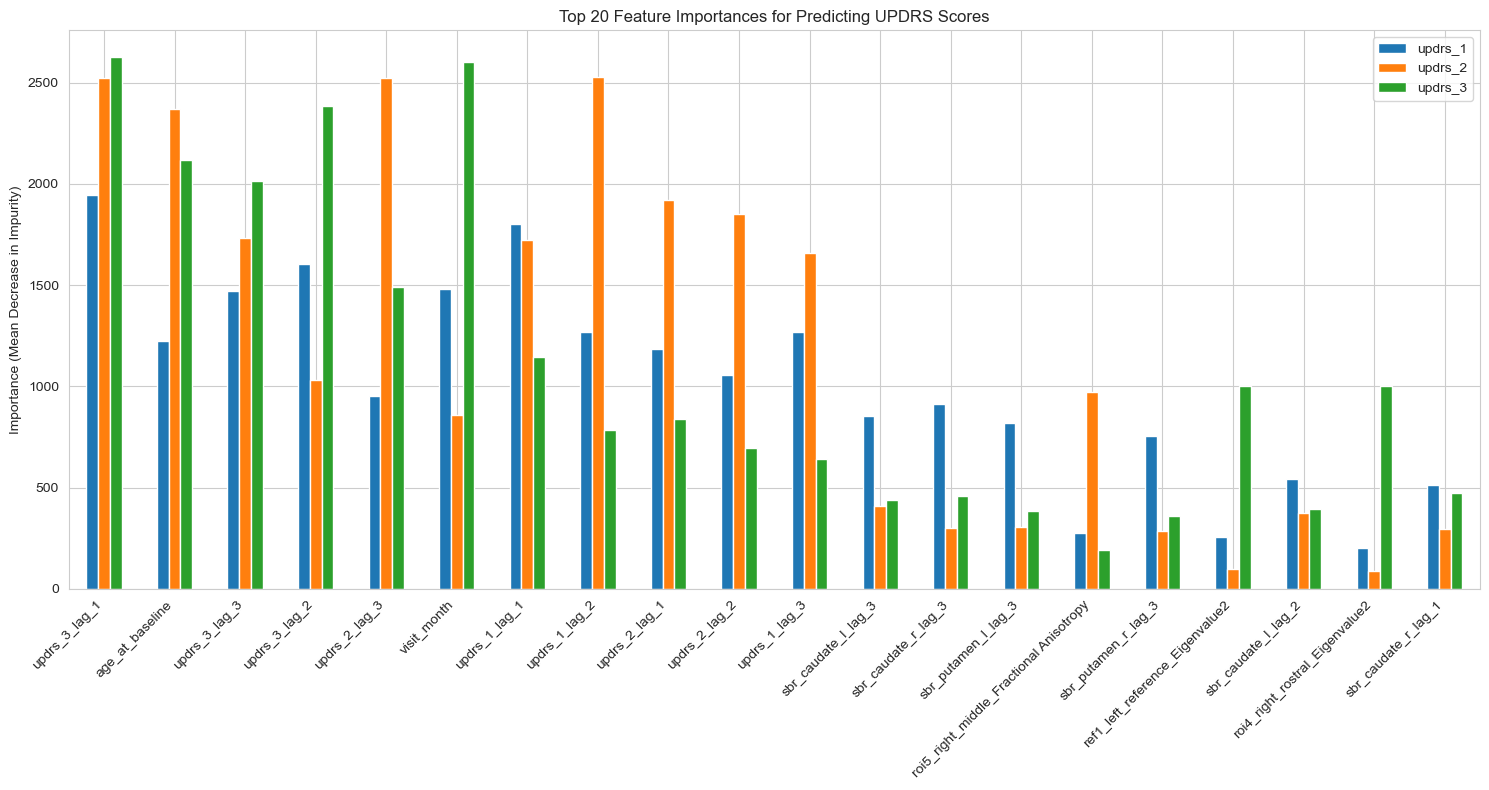

In [8]:
model=models[-1]
print("\n--- Feature Importance (from last fold's model) ---")
importance_df = pd.DataFrame(index=final_feature_cols)

for i, estimator in enumerate(model.estimators_):
    target_name = updrs_cols[i]
    importances = estimator.feature_importances_
    importance_df[target_name] = importances

importance_df['average_importance'] = importance_df.mean(axis=1)
importance_df.to_csv("feature_importance_LGBM.csv")
top_features = importance_df.sort_values(by='average_importance', ascending=False).head(20)

print("Top 20 Features (Averaged Across UPDRS Targets):")
print(top_features)

top_features[updrs_cols].plot(kind='bar', figsize=(15, 8))
plt.title('Top 20 Feature Importances for Predicting UPDRS Scores')
plt.ylabel('Importance (Mean Decrease in Impurity)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Analysis

### The Patient's Most Recent History has great importance:

The most important features by a large margin will be the lagged versions of the UPDRS scores themselves. This confirms with our intuition that the disease is strongly autoregressive: the best predictor of a patient's near-future state is their immediate past state.

### Time and Age are Fundamental:

`visit_month` and `age_at_baseline` will be the next most important features. They provide the fundamental context of "where" the patient is in their disease timeline and their biological starting point.

### Other Clinical Markers Provide Additional Signal:

Lagged, time-dependent clinical features, especially the SBR (striatal binding ratio) imaging markers like sbr_putamen_r_lag_1, will likely rank as moderately important. They provide predictive information that the lagged UPDRS scores alone don't capture.

### Other Static Demographics are Less Impactful:

The remaining static features (e.g., race, education level) will have much lower importance scores compared to the dynamic (time-varying) features.